In [274]:
import pandas as pd
import numpy as np
import os
import math

# visuals
import matplotlib.pyplot as plt

import seaborn as sns
from seaborn import heatmap

# .py files
import wrangle as wr


In [94]:

import xgboost


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from seaborn import heatmap
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import statistics


import xgboost as xgb
from sklearn.metrics import mean_squared_error

# data split
from sklearn.model_selection import train_test_split

# sklearn metrics
from sklearn.metrics import accuracy_score, precision_score


import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier

# Decision Tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Logistic Regression
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

# importing data

In [2]:
df = pd.read_csv('neo_v2.csv')

# checking data and prepping

In [3]:
# they all orbit earth
df = df.drop(columns = 'orbiting_body')

In [4]:
# these are all exlcuded from the sentry automated collison monitoring system
df = df.drop(columns = 'sentry_object')

In [5]:
df.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,False


In [6]:
df['hazardous'] = df['hazardous'].astype(int)

In [7]:
df.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2162635,162635 (2000 SS164),1.198271,2.679415,13569.249224,5.483974e+07,16.73,0


In [8]:
# checking to make sure data is fine to work with
df.dtypes

id                      int64
name                   object
est_diameter_min      float64
est_diameter_max      float64
relative_velocity     float64
miss_distance         float64
absolute_magnitude    float64
hazardous               int64
dtype: object

# the goal of this project is to see wether or not we can classify a asteroid as hazardous 

In [9]:
len(df.columns)

8

In [10]:
numerical = df.select_dtypes(include = 'number')
len(numerical.columns)

7

In [11]:
categorical = df.select_dtypes(exclude = 'number')
len(categorical.columns)

1

In [12]:
df.describe()

,id,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
count,9.083600e+04,90836.000000,90836.000000,90836.000000,9.083600e+04,90836.000000,90836.000000
mean,1.438288e+07,0.127432,0.284947,48066.918918,3.706655e+07,23.527103,0.097318
std,2.087202e+07,0.298511,0.667491,25293.296961,2.235204e+07,2.894086,0.296392
min,2.000433e+06,0.000609,0.001362,203.346433,6.745533e+03,9.230000,0.000000
25%,3.448110e+06,0.019256,0.043057,28619.020645,1.721082e+07,21.340000,0.000000
50%,3.748362e+06,0.048368,0.108153,44190.117890,3.784658e+07,23.700000,0.000000
75%,3.884023e+06,0.143402,0.320656,62923.604633,5.654900e+07,25.700000,0.000000
max,5.427591e+07,37.892650,84.730541,236990.128088,7.479865e+07,33.200000,1.000000


# exploring numericals

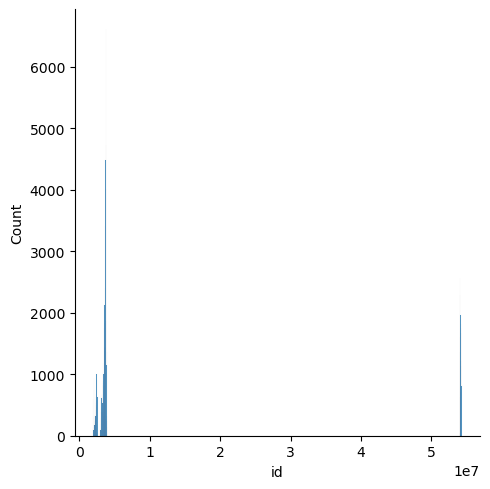

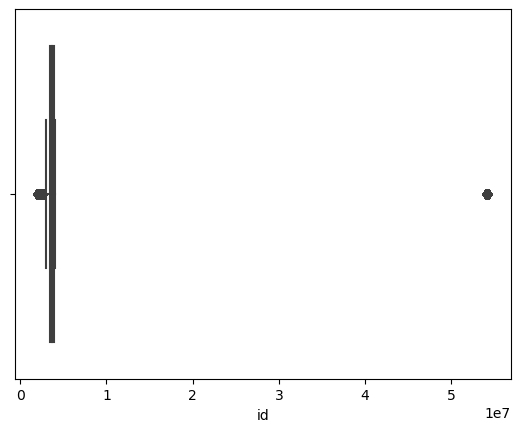

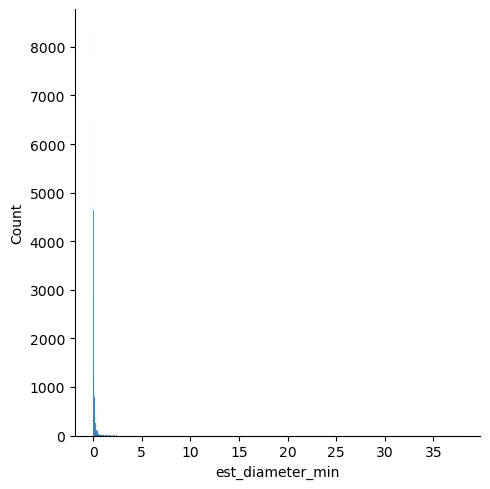

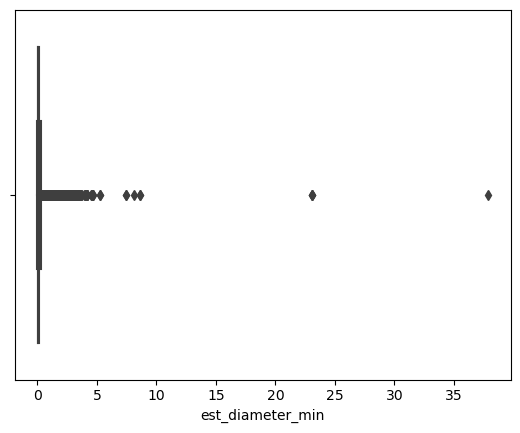

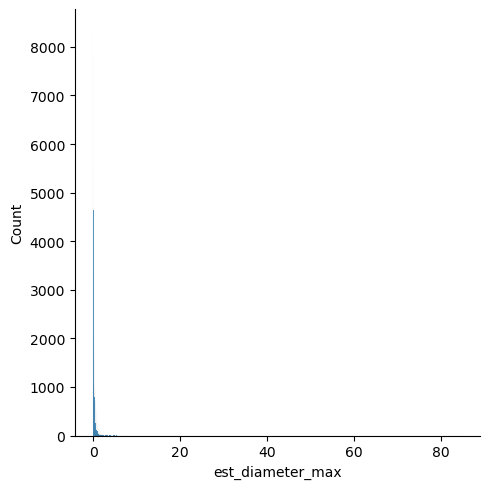

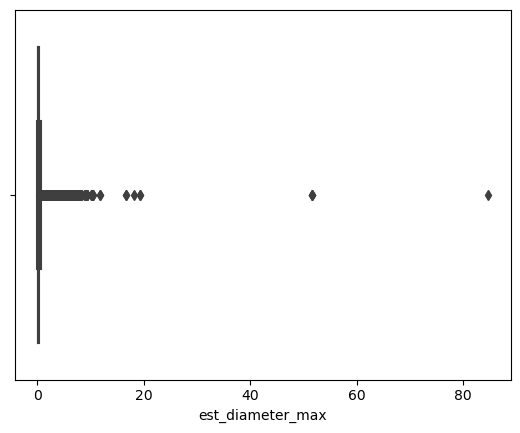

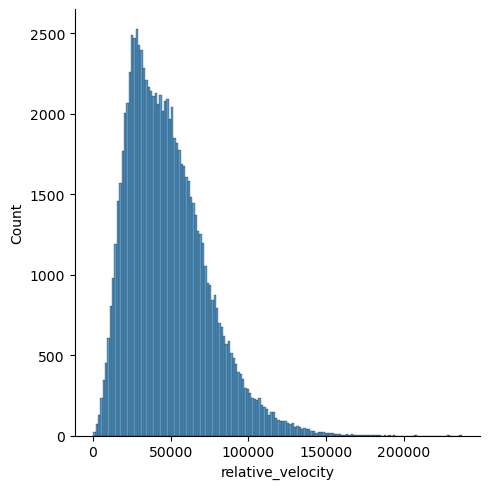

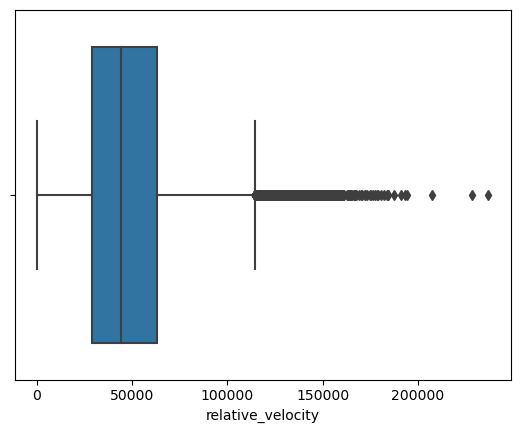

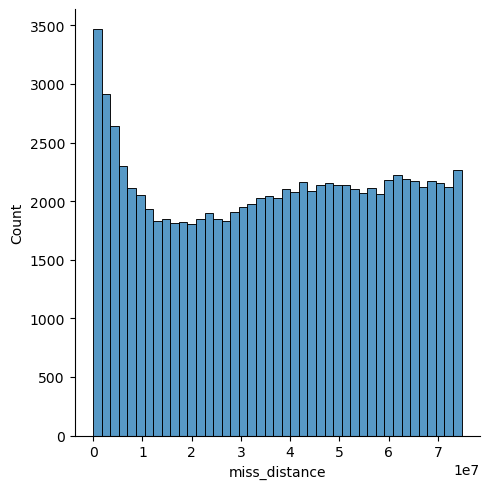

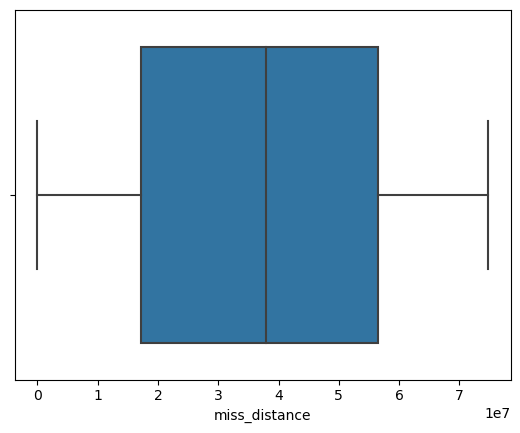

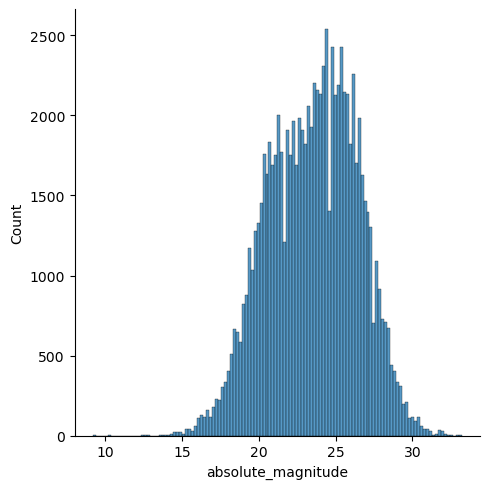

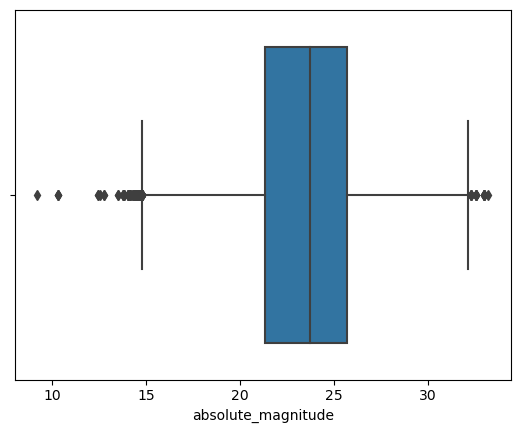

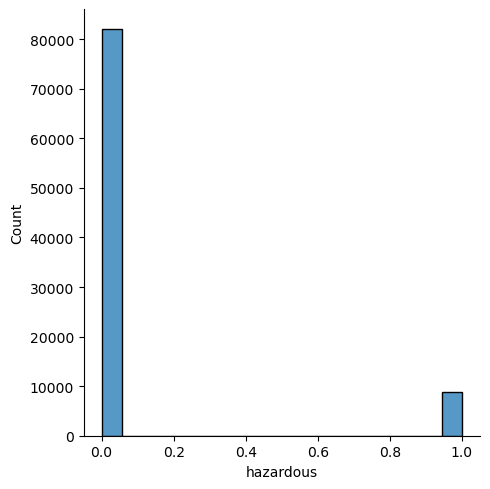

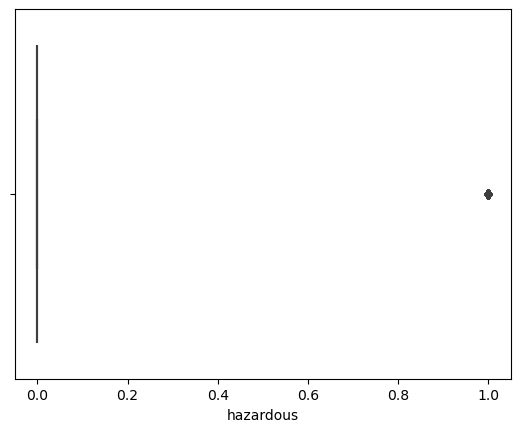

In [13]:
for col in numerical.columns:
    
    sns.displot(data= numerical,x = col)
    
    plt.show()
    
    
    # box plot, outlier check
    sns.boxplot(data= numerical,x = col)
    
    
    plt.show()
    

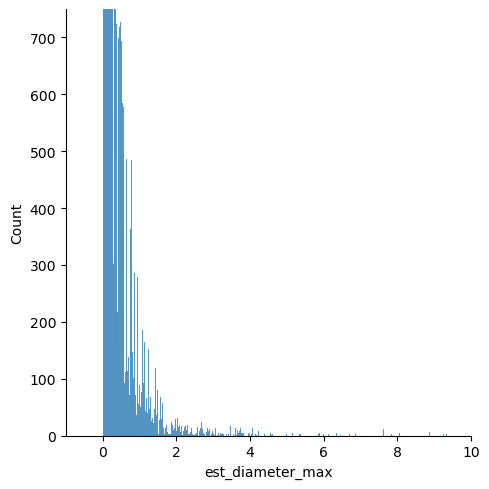

In [14]:
sns.displot(data= numerical,x = 'est_diameter_max')
plt.ylim(0,750)
plt.xlim(-1,10)
plt.show()
    

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* There are two data points with outliers `min diameter`
* There are two data points with outliers `max diameter`(most likely the same two)
* more of data points have a near miss of about 1 or less


# exploring categoricals

In [15]:
categorical.head(1)

,name
0,162635 (2000 SS164)


In [16]:
# sns.countplot(data= categorical,x = "hazardous")
# plt.show()

<div class="alert alert-block alert-info">
<b>Hazardous:</b>  we have found more benign near earth objects than hazardous

# train split data

In [17]:
def split_data(df,strat):
    ''' 
    splits data frame and returns a train, validate, 
    and test data frame stratified on churn 
    '''
    
    # split df into train_validate and test
    train_validate, test = train_test_split(df,test_size =.2, 
                                             random_state = 42,
                                             stratify = df[strat])
    
    # split train_validate into train and validate
    train, validate = train_test_split(train_validate,
                                      test_size = .3,
                                      random_state = 42,
                                      stratify = train_validate[strat])
                                            
    # reset index for train validate and tes
    train.reset_index(drop=True, inplace=True)
    validate.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)
    
    print (train.shape,test.shape,validate.shape)
    return train, validate, test

In [18]:
# checking to see the shape and checking the data frames

In [19]:
train,validate, test = split_data(df,'hazardous')

(50867, 8) (18168, 8) (21801, 8)


In [20]:
train.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2512245,512245 (2016 AU8),0.288772,0.645714,29196.269134,3.049479e+07,19.82,0


In [21]:
test.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,2474532,474532 (2003 VG1),0.472667,1.056915,21779.237137,3.443050e+07,18.75,0


In [22]:
validate.head(1)

,id,name,est_diameter_min,est_diameter_max,relative_velocity,miss_distance,absolute_magnitude,hazardous
0,3704141,(2015 AY245),0.168483,0.376738,23575.847178,3.791253e+07,20.99,1


# multi_variate

In [23]:
matrix = train.corr()

<AxesSubplot:>

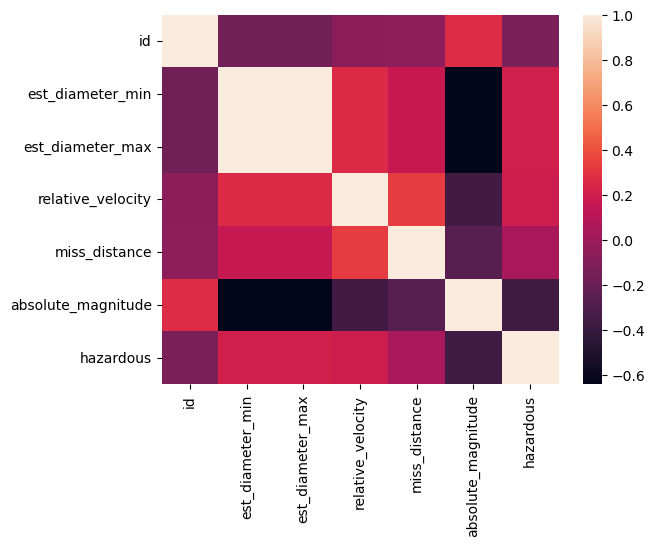

In [24]:
heatmap(matrix)


<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
* hazardous has a negative correlation to absoulte_magnitude
* hazardous has a positive correlation to `relative_velocity`, `diameter_max`, and `diameter_min`

* `absolute_magnitude` has a strong negative correlation with diameter. the less visablity an object has the more likely it is to be smaller.
* `rel_velocity` and the `diameter` are correlated

<div class="alert alert-block alert-success">
<b>Questions:</b>
    
* if i group hazardous and not hazardous, will the max diameter mean be different between the two?
* if i group hazardous and not hazardous, will there be a significant differce in absolute magnitude
* is the correlation between diameter and hazardous significant


# explore questions

### how many objects are hazardous and how many are inert

In [25]:
haz = df[df.hazardous == 1]
safe = df[df.hazardous == 0]

In [26]:
len(haz) / len(safe)
# 10 percent of our data is dangerous

0.10781013707985755

In [27]:
# i want to add gray spots to make it look like an astroid

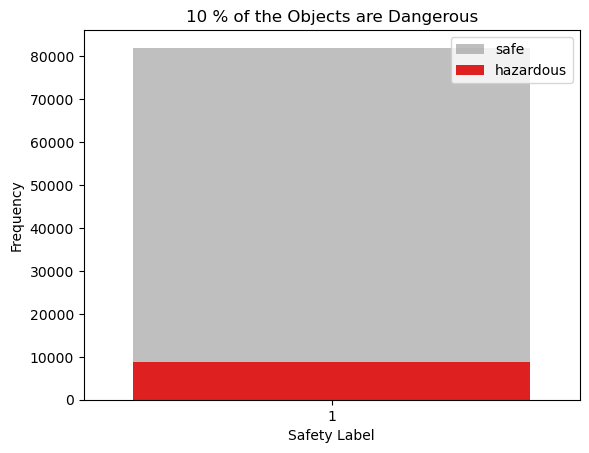

In [29]:
### if i group hazardous and not hazardous, will the min diameter mean be different between the two?

(0.0, 100.0)

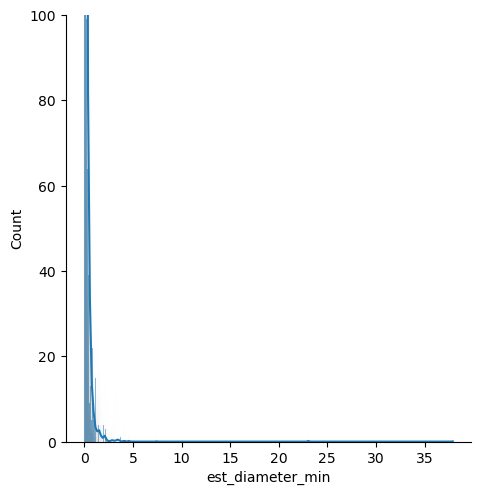

In [30]:
sns.displot(data = safe.est_diameter_min,kde = 'line')
plt.ylim(0,100)

(0.0, 100.0)

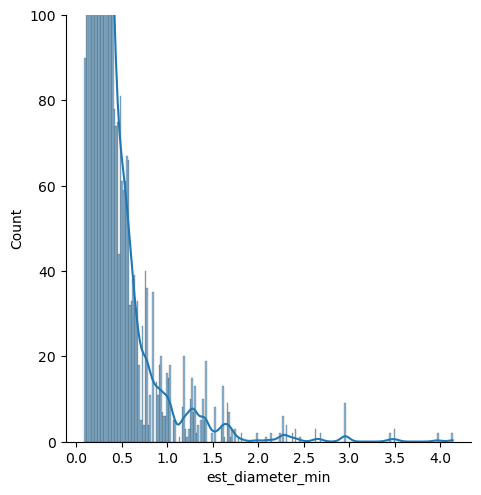

In [31]:
sns.displot(data = haz.est_diameter_min,kde = 'line')
plt.ylim(0,100)

<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
    
$Ho$ : Mean of est_diameter_min of astroids that are hazardous = Mean of est_diameter_min of that are NOT hazardous

$Ha$ : Mean of est_diameter_min of astroids that are hazardous =! Mean of est_diameter_min of that are NOT hazardous

In [32]:
saf_min = safe.est_diameter_min

In [33]:
saf_min.mean()

0.10945994486417701

In [34]:
haz_min = haz.est_diameter_min

In [35]:
haz_min.mean()

0.2941340690233259

In [36]:
t, p= mannwhitneyu(haz_min, saf_min)

In [37]:
print('Statistics=%.2f, p=%.2f' % (t, p))


Statistics=627036894.00, p=0.00


In [38]:
a = 0.05
# conclusion
if p < a:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* splitting the groups into safe and not safe objects, you can see that the there is a significant mean difference in the min diameter meaning this may have some influence in our model



# if i group hazardous and not hazardous, will there be a significant differce in absolute magnitude

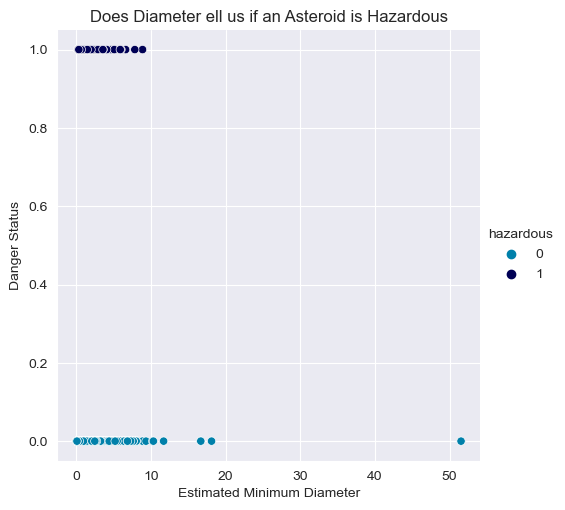

In [306]:
sns.set_style('darkgrid')
sns.relplot(data = train, x = 'est_diameter_max',y= 'hazardous',hue = "hazardous",palette = "ocean_r")
plt.title('Does Diameter ell us if an Asteroid is Hazardous')
plt.ylabel('Danger Status')
plt.xlabel('Estimated Minimum Diameter')
 

None

(0.0, 100.0)

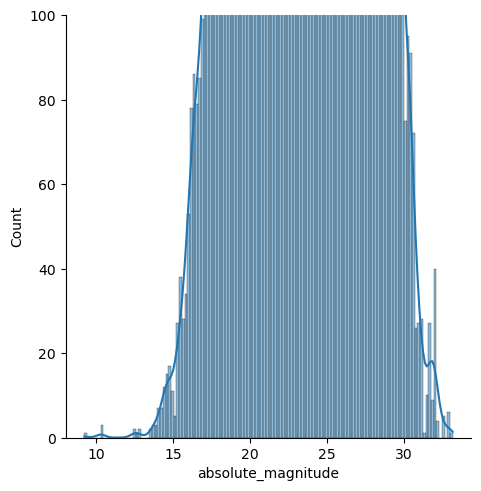

In [39]:
sns.displot(data = safe.absolute_magnitude,kde = 'line')
plt.ylim(0,100)

(0.0, 100.0)

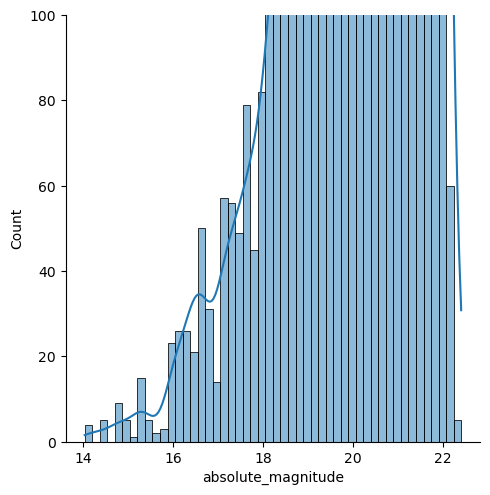

In [40]:
sns.displot(data = haz.absolute_magnitude,kde = 'line')
plt.ylim(0,100)

In [41]:
haz_mag = haz.absolute_magnitude 

In [42]:
saf_mag = safe.absolute_magnitude 

In [43]:
print(haz_mag.var())
print(saf_mag.var())

1.8000944781022008
7.846715845803671


In [44]:
t, p = stats.ttest_ind(haz_mag, saf_mag, equal_var=False)

t, p

(-206.14921177684386, 0.0)

In [45]:
# conclusion
if p < a:
    print('Reject Null Hypothesis (Significant difference between two samples)')
else:
    print('Do not Reject Null Hypothesis (No significant difference between two samples)')

Reject Null Hypothesis (Significant difference between two samples)


In [ ]:
<div class="alert alert-block alert-info">
<b>Take Aways:</b>  
* splitting the groups into safe and not safe objects, you can see that the there is a significant mean difference in the absolute magnitude meaning this may have some influence in our model
* the visbility of an object plays a roll into categorizing it as safe or not


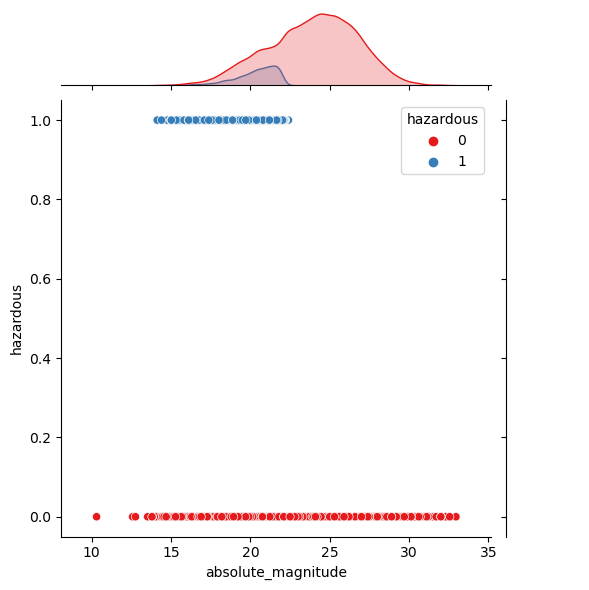

In [46]:
sns.jointplot(data = train, x = 'absolute_magnitude', y = 'hazardous',hue = 'hazardous',palette = 'Set1' )

In [47]:
# the brighter you are the less chance of being hazardous

# Modeling 

In [48]:
def x_and_y(train,validate,test,target):
    
    """
    splits train, validate, and target into x and y versions
    """

    x_train = train.drop(columns= target)
    y_train = train[target]

    x_validate = validate.drop(columns= target)
    y_validate = validate[target]

    x_test = test.drop(columns= target)
    y_test = test[target]
    
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    y_test = pd.DataFrame(y_test)


    return x_train,y_train,x_validate,y_validate,x_test, y_test

In [49]:
x_train,y_train,x_validate,y_validate,x_test, y_test = x_and_y(train,validate,test,'hazardous')

# selecting model features

In [50]:
x_train = x_train.drop(columns = ['id','name'])
x_validate = x_validate.drop(columns = ['id','name'])
x_test= x_test.drop(columns = ['id','name'])

### baseline

In [51]:
# Calculate the baseline prediction
baseline_pred = [statistics.mode(y_train['hazardous'])] * len(y_train['hazardous'])

# Calculate the accuracy score
baseline_accuracy = accuracy_score(y_train['hazardous'], baseline_pred)
print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

# Calculate the precision score
baseline_precision = precision_score(y_train['hazardous'], baseline_pred, average='macro')
print(f"Baseline Precision: {baseline_precision:.2f}")

Baseline Accuracy: 0.90
Baseline Precision: 0.45


In [52]:
def baseline(y_train,y_validate,target):
    
    '''a function to return our baseline and create a dataframe to hold all the models and their features'''
    
    # turning our series into a data frame
    y_train = pd.DataFrame(y_train)
    y_validate = pd.DataFrame(y_validate)
    
    
     # predict target value mode
    train_mode = y_train[target].mode()[0]
    validate_mode = y_validate[target].mode()[0]
   
    # predict tax value mode
    y_train[target + '_mode_baseline'] = train_mode
    y_validate[target + '_mode_baseline'] = validate_mode
    
    matching_values = (y_train['hazardous'] == y_train['hazardous_mode_baseline']).sum()

  # Calculate the baseline prediction
    baseline_pred = [statistics.mode(y_train['hazardous'])] * len(y_train['hazardous'])

    # Calculate the accuracy score
    baseline_accuracy = accuracy_score(y_train['hazardous'], baseline_pred)
    print(f"Baseline Accuracy: {baseline_accuracy:.2f}")

    # Calculate the precision score
    baseline_precision = precision_score(y_train['hazardous'], baseline_pred, average='macro')
    print(f"Baseline Precision: {baseline_precision:.2f}")
    
    # creating a new series to hold our results of all model performance
    evals = {'Precision': [baseline_precision], 'model': ['baseline']}

    # creating a data frame from our series to pass on
    evals = pd.DataFrame(data=evals)
    
    return y_train,y_validate,evals

In [53]:
y_train,y_validate,evals = baseline(y_train,y_validate,'hazardous')

Baseline Accuracy: 0.90
Baseline Precision: 0.45


In [54]:
evals

,Precision,model
0,0.451344,baseline


# decision tree

In [55]:
def decision_tree(x_train, y_train, x_validate, y_validate, x_test, y_test, md):
    clf = DecisionTreeClassifier(random_state=42)
    results = []
    for i in range(1, md+1):
        clf = DecisionTreeClassifier(max_depth=i, random_state=42)
        clf.fit(x_train, y_train['hazardous'])
        
        # Accuracy and precision for the training data
        y_train_pred = clf.predict(x_train)
        train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
        train_precision = precision_score(y_train['hazardous'], y_train_pred)
       
         # Accuracy and precision for the validate data
        y_validate_pred = clf.predict(x_validate)
        validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
        validate_precision = precision_score(y_validate['hazardous'], y_validate_pred)
    
        # Accuracy and precision for the test data
        y_test_pred = clf.predict(x_test)
        test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
        test_precision = precision_score(y_test['hazardous'], y_test_pred)
        
        results.append({'Max Depth': i, 
                        'Train Accuracy': train_accuracy,
                        'Train Precision': train_precision,
                        'Validate Accuracy': validate_accuracy,
                        'validate Precision': validate_precision,
                        'Test Accuracy': test_accuracy,
                        'Test Precision': test_precision})
        
    results_df = pd.DataFrame(results)
    return results_df

In [56]:
results = decision_tree(x_train, y_train, x_validate,y_validate, x_test, y_test, 20)
results.sort_values(by = "Test Precision").tail(1)

,Max Depth,Train Accuracy,Train Precision,Validate Accuracy,validate Precision,Test Accuracy,Test Precision
3,4,0.912497,0.884438,0.910463,0.829457,0.913364,0.921739


In [57]:
# take aways: 
# a decision tree with the max depth of 4 has the highest precison as .92%

In [58]:
def add_dt_test(x_train, y_train, x_test, y_test, md,evals):
    
    clf = DecisionTreeClassifier(max_depth=md, random_state=42)
    
    clf.fit(x_train, y_train['hazardous'])
    
    # Accuracy and precision for the test data
    y_test_pred = clf.predict(x_test)
    test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
    test_precision = precision_score(y_test['hazardous'], y_test_pred)
    
    decision = {'Precision': test_precision, 'model': 'decision tree'}
    evals = evals.append(decision, ignore_index = True)
    
    return evals
    
    
    

In [59]:
add_dt_test(x_train, y_train, x_test, y_test, 4,evals)


,Precision,model
0,0.451344,baseline
1,0.921739,decision tree


In [60]:
evals

,Precision,model
0,0.451344,baseline


# random forest

In [61]:
def random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, md):
    clf = RandomForestClassifier(random_state=42)
    results = []
    for i in range(1, md+1):
        clf = RandomForestClassifier(max_depth=i, random_state=42)
        
        clf.fit(x_train, y_train['hazardous'])
        
        # Accuracy and precision for the training data
        y_train_pred = clf.predict(x_train)
        train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
        train_precision = precision_score(y_train['hazardous'], y_train_pred)
       
         # Accuracy and precision for the validate data
        y_validate_pred = clf.predict(x_validate)
        validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
        validate_precision = precision_score(y_validate['hazardous'], y_validate_pred)
    
        # Accuracy and precision for the test data
        y_test_pred = clf.predict(x_test)
        test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
        test_precision = precision_score(y_test['hazardous'], y_test_pred)
        
        results.append({'Max Depth': i, 
                        'Train Accuracy': train_accuracy,
                        'Train Precision': train_precision,
                        'Validate Accuracy': validate_accuracy,
                        'validate Precision': validate_precision,
                        'Test Accuracy': test_accuracy,
                        'Test Precision': test_precision})
    results_df = pd.DataFrame(results)
    return results_df

In [62]:
results_df = random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, 20)

In [63]:
results_df.sort_values(by = 'Test Precision').tail(1)

,Max Depth,Train Accuracy,Train Precision,Validate Accuracy,validate Precision,Test Accuracy,Test Precision
3,4,0.912655,0.868996,0.911059,0.830325,0.914025,0.90873


In [64]:
def random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, n_estimators, max_depth):
    results = []
    for n in n_estimators:
        for d in max_depth:
            clf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42)
            clf.fit(x_train, y_train['hazardous'])

            # Accuracy and precision for the training data
            y_train_pred = clf.predict(x_train)
            train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
            train_precision = precision_score(y_train['hazardous'], y_train_pred)

            # Accuracy and precision for the validate data
            y_validate_pred = clf.predict(x_validate)
            validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
            validate_precision = precision_score(y_validate['hazardous'], y_validate_pred)

            # Accuracy and precision for the test data
            y_test_pred = clf.predict(x_test)
            test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
            test_precision = precision_score(y_test['hazardous'], y_test_pred)

            results.append({'n_estimators': n,
                            'max_depth': d,
                            'Train Accuracy': train_accuracy,
                            'Train Precision': train_precision,
                            'Validate Accuracy': validate_accuracy,
                            'validate Precision': validate_precision,
                            'Test Accuracy': test_accuracy,
                            'Test Precision': test_precision})
    results_df = pd.DataFrame(results)
    return results_df

In [67]:
n_estimators = range(1, 10)
max_depth = range(1, 10)


In [68]:
results_df = random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, n_estimators, max_depth)


In [69]:
results_df.sort_values(by = 'Test Precision').tail(1)

,n_estimators,max_depth,Train Accuracy,Train Precision,Validate Accuracy,validate Precision,Test Accuracy,Test Precision
50,6,6,0.912025,0.908778,0.910004,0.847826,0.912539,0.912442


In [ ]:
# these setting gave us our best test precision

# knn 

In [83]:
def get_knn(x_train, y_train, x_validate, y_validate, x_test, y_test, nn):
    
    weights = ['uniform', 'distance']
    results = []
    for i in range(1, nn+1):
        for w in weights:
            knn = KNeighborsClassifier(n_neighbors=nn, weights= w )

            knn.fit(x_train, y_train['hazardous'])
        
            # Accuracy and precision for the training data
            y_train_pred = knn.predict(x_train)
            train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
            train_precision = precision_score(y_train['hazardous'], y_train_pred)
       
            # Accuracy and precision for the validate data
            y_validate_pred = knn.predict(x_validate)
            validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
            validate_precision = precision_score(y_validate['hazardous'], y_validate_pred)
    
            # Accuracy and precision for the test data
            y_test_pred = knn.predict(x_test)
            test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
            test_precision = precision_score(y_test['hazardous'], y_test_pred)
        
            results.append({'N_neighbors': i, 
                        'Weights': w,
                        'Train Accuracy': train_accuracy,
                        'Train Precision': train_precision,
                        'Validate Accuracy': validate_accuracy,
                        'validate Precision': validate_precision,
                        'Test Accuracy': test_accuracy,
                        'Test Precision': test_precision})
        
    results_df = pd.DataFrame(results)
    return results_df

In [91]:
results_df = get_knn(x_train, y_train, x_validate, y_validate, x_test, y_test, 40)


In [92]:
results_df.sort_values(by = 'Test Precision').tail(1)

,N_neighbors,Weights,Train Accuracy,Train Precision,Validate Accuracy,validate Precision,Test Accuracy,Test Precision
79,40,distance,1.0,1.0,0.904958,0.765957,0.904668,0.764706


# XGBoost

In [241]:
param_grid = {
    'max_depth':[3,4,5],
    'learning_rate':[.1,.01,.05],
    'gamma': [0,.25,1.0],
    'reg_lambda':[0,1.0,10],
    'scale_pos_weight':[1,3,5]   
}

In [246]:
clf_xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                        seed = 42,
                                        max_depth = 3,    
                                        scale_pos_weight= 1,
                                        learning_rate = .1,
                                        subsample = .9,
                                        colsample_bytree = .5,
                                        n_jobs = 10)

In [247]:
clf_xgb.fit(x_train,y_train['hazardous'],verbose = True)
None

In [248]:
preds = clf_xgb.predict(x_test)

In [249]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [250]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 0.292652


In [251]:
test_accuracy = accuracy_score(y_test['hazardous'],preds)
test_precision = precision_score(y_test['hazardous'],preds)

In [252]:
test_accuracy ,test_precision

(0.9143549097313959, 0.8333333333333334)

In [261]:
def random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, max_depth,scale_pos_weight,learning_rate):
    results = []
    
    for md in max_depth:
        for sw in scale_pos_weight:
            for lr in learning_rate:
                
                clf_xgb = xgb.XGBClassifier(objective ='binary:logistic', 
                                            random_state = 42,
                                            max_depth = md,    
                                            scale_pos_weight= sw,
                                            learning_rate = lr,
                                            subsample = .9,
                                            colsample_bytree = .5,
                                            n_jobs = 10)
                
                
                clf_xgb.fit(x_train,
                            y_train['hazardous'],

                            eval_metric = 'auc',
                            verbose = False)
                

                # Accuracy and precision for the training data
                y_train_pred = clf_xgb.predict(x_train)
                train_accuracy = accuracy_score(y_train['hazardous'], y_train_pred)
                train_precision = precision_score(y_train['hazardous'], y_train_pred)

                # Accuracy and precision for the validate data
                y_validate_pred = clf_xgb.predict(x_validate)
                validate_accuracy = accuracy_score(y_validate['hazardous'], y_validate_pred)
                validate_precision = precision_score(y_validate['hazardous'], y_validate_pred)

                # Accuracy and precision for the test data
                y_test_pred = clf_xgb.predict(x_test)
                test_accuracy = accuracy_score(y_test['hazardous'], y_test_pred)
                test_precision = precision_score(y_test['hazardous'], y_test_pred)

                results.append({'scale_pos_weight': sw,
                                'learning_rate':lr,
                            'max_depth': md,
                            'Train Accuracy': train_accuracy,
                            'Train Precision': train_precision,
                            'Validate Accuracy': validate_accuracy,
                            'validate Precision': validate_precision,
                            'Test Accuracy': test_accuracy,
                            'Test Precision': test_precision})
    results_df = pd.DataFrame(results)
    return results_df

In [262]:
max_depth = [3,4,5]
scale_pos_weight=[1,3,5]
learning_rate = [.1,.01,.05]

In [264]:
results = random_forest(x_train, y_train, x_validate, y_validate, x_test, y_test, max_depth,scale_pos_weight,learning_rate)


In [268]:
results.sort_values(by = "Test Precision").tail(5)

,scale_pos_weight,learning_rate,max_depth,Train Accuracy,Train Precision,Validate Accuracy,validate Precision,Test Accuracy,Test Precision
2,1,0.05,3,0.912792,0.857939,0.911059,0.814433,0.913639,0.881226
11,1,0.05,4,0.913087,0.859864,0.911197,0.810000,0.914025,0.881481
19,1,0.01,5,0.910787,0.955752,0.909133,0.927273,0.910502,0.961039
1,1,0.01,3,0.910079,0.951923,0.908857,0.941176,0.910007,0.971631
10,1,0.01,4,0.910119,0.954327,0.908995,0.936709,0.910227,0.972414
